# Background, motivation and set up

**Objective**: Compare attributions using integrated gradients and activation patching, and investigate the discrepancies between the two methods.

**Motivation**:

- Understand when and why do IG and AP disagree: e.g. methodological limitations, or suitability to model tasks, etc.
- Investigate if discrepancies help uncover different hidden model behaviours
- Understand when and why linear approximations to activation patching fail
- Investigate limitations of using activation patching for evaluations: if results are different because of other unknown factors (not just because the method evaluated is "incorrect")

**Set-up**:

We load the transformer model GPT2-Small, which has 12 layers, 12 attention heads per layer, embedding size 768 and 4 x 768 = 3,072 neurons in each feed-forward layer. We use GPT2-Small because 1) it is a relatively small transformer model which has comparable behaviour to larger SOTA models, and 2) there is a lot of interpretability literature which focuses on circuits in this model.

In [53]:
import torch
import numpy as np

from captum.attr import LayerIntegratedGradients

from transformer_lens.utils import get_act_name, get_device
from transformer_lens import ActivationCache, HookedTransformer, HookedTransformerConfig
from transformer_lens.hook_points import HookPoint

import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
device = get_device()
model = HookedTransformer.from_pretrained("gpt2-small", device=device)

Loaded pretrained model gpt2-small into HookedTransformer


# Attribution for GPT2-Small

We scale up our earlier experiments to implement integrated gradients and activation patching on a larger transformer model. We use the same counterfactual inputs, based on the Indirect Object Identification task.

In [91]:
#| output: true

clean_prompt = "After John and Mary went to the store, Mary gave a bottle of milk to"
corrupted_prompt = "After John and Mary went to the store, John gave a bottle of milk to"

clean_input = model.to_tokens(clean_prompt)
corrupted_input = model.to_tokens(corrupted_prompt)

def logits_to_logit_diff(logits, correct_answer=" John", incorrect_answer=" Mary"):
    # model.to_single_token maps a string value of a single token to the token index for that token
    correct_index = model.to_single_token(correct_answer)
    incorrect_index = model.to_single_token(incorrect_answer)
    return logits[0, -1, correct_index] - logits[0, -1, incorrect_index]

# Explicitly calculate and expose the result for each attention head
model.set_use_attn_result(True)
model.set_use_hook_mlp_in(True)

clean_logits, clean_cache = model.run_with_cache(clean_input)
clean_logit_diff = logits_to_logit_diff(clean_logits)
print(f"Clean logit difference: {clean_logit_diff.item():.3f}")

corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_input)
corrupted_logit_diff = logits_to_logit_diff(corrupted_logits)
print(f"Corrupted logit difference: {corrupted_logit_diff.item():.3f}")

Clean logit difference: 4.276
Corrupted logit difference: -2.738


In [100]:
model.cfg

HookedTransformerConfig:
{'NTK_by_parts_factor': 8.0,
 'NTK_by_parts_high_freq_factor': 4.0,
 'NTK_by_parts_low_freq_factor': 1.0,
 'act_fn': 'gelu_new',
 'attention_dir': 'causal',
 'attn_only': False,
 'attn_scale': 8.0,
 'attn_scores_soft_cap': -1.0,
 'attn_types': None,
 'checkpoint_index': None,
 'checkpoint_label_type': None,
 'checkpoint_value': None,
 'd_head': 64,
 'd_mlp': 3072,
 'd_model': 768,
 'd_vocab': 50257,
 'd_vocab_out': 50257,
 'decoder_start_token_id': None,
 'default_prepend_bos': True,
 'device': device(type='mps'),
 'dtype': torch.float32,
 'eps': 1e-05,
 'experts_per_token': None,
 'final_rms': False,
 'from_checkpoint': False,
 'gated_mlp': False,
 'init_mode': 'gpt2',
 'init_weights': False,
 'initializer_range': 0.02886751345948129,
 'load_in_4bit': False,
 'model_name': 'gpt2',
 'n_ctx': 1024,
 'n_devices': 1,
 'n_heads': 12,
 'n_key_value_heads': None,
 'n_layers': 12,
 'n_params': 84934656,
 'normalization_type': 'LNPre',
 'num_experts': None,
 'original_

## Integrated Gradients

In [ ]:
def run_from_layer_fn(x, original_input, prev_layer):
    # Force the layer before the target layer to output the given values, i.e. pass the given input into the target layer
    # original_input value does not matter; useful to keep shapes nice, but its activations will be overwritten
    logits = model.run_with_hooks(
        original_input,
        fwd_hooks=[(prev_layer.name, lambda act, hook: x)]
    )
    logit_diff = logits_to_logit_diff(logits).unsqueeze(0)
    return logit_diff

def compute_layer_to_output_attributions(original_input, layer_input, layer_baseline, target_layer, prev_layer):
    # Take the model starting from the target layer
    forward_fn = lambda x: run_from_layer_fn(x, original_input, prev_layer)
    # Attribute to the target_layer's output
    ig_embed = LayerIntegratedGradients(forward_fn, target_layer, multiply_by_inputs=True)
    attributions, approximation_error = ig_embed.attribute(inputs=layer_input,
                                                    baselines=layer_baseline, 
                                                    attribute_to_layer_input=False,
                                                    return_convergence_delta=True)
    print(f"\nError (delta) for {target_layer.name} attribution: {approximation_error.item()}")
    return attributions

In [94]:
# Gradient attribution for neurons in MLP layers
mlp_ig_results = torch.zeros(model.cfg.n_layers, model.cfg.d_mlp)
# Gradient attribution for attention heads
attn_ig_results = torch.zeros(model.cfg.n_layers, model.cfg.n_heads)

# Calculate integrated gradients for each layer
for layer in range(model.cfg.n_layers):
    # Gradient attribution on heads
    hook_name = get_act_name("result", layer)
    target_layer = model.hook_dict[hook_name]
    prev_layer_hook = get_act_name("z", layer)
    prev_layer = model.hook_dict[prev_layer_hook]

    layer_clean_input = clean_cache[prev_layer_hook]
    layer_corrupt_input = corrupted_cache[prev_layer_hook]

    attributions = compute_layer_to_output_attributions(clean_input, layer_clean_input, layer_corrupt_input, target_layer, prev_layer) # shape [1, seq_len, d_head, d_model]
    # Calculate attribution score based on mean over each embedding, for each token
    print(attributions.shape)
    per_token_score = attributions.mean(dim=3)
    score = per_token_score.mean(dim=1)
    attn_ig_results[layer] = score

    # Gradient attribution on MLP neurons
    hook_name = get_act_name("post", layer)
    target_layer = model.hook_dict[hook_name]
    prev_layer_hook = get_act_name("mlp_in", layer)
    prev_layer = model.hook_dict[prev_layer_hook]

    layer_clean_input = clean_cache[prev_layer_hook]
    layer_corrupt_input = corrupted_cache[prev_layer_hook]
    
    attributions = compute_layer_to_output_attributions(clean_input, layer_clean_input, layer_corrupt_input, target_layer, prev_layer) # shape [1, seq_len, d_model]
    print(attributions.shape)
    score = attributions.mean(dim=1)
    mlp_ig_results[layer] = score

blocks.0.attn.hook_result

Error (delta) for blocks.0.attn.hook_result attribution: 0.09300675243139267
torch.Size([1, 17, 12, 768])
blocks.0.mlp.hook_post

Error (delta) for blocks.0.mlp.hook_post attribution: -5.157962799072266
torch.Size([1, 17, 3072])
blocks.1.attn.hook_result

Error (delta) for blocks.1.attn.hook_result attribution: -0.055533651262521744
torch.Size([1, 17, 12, 768])
blocks.1.mlp.hook_post

Error (delta) for blocks.1.mlp.hook_post attribution: 0.11043720692396164
torch.Size([1, 17, 3072])
blocks.2.attn.hook_result

Error (delta) for blocks.2.attn.hook_result attribution: 0.012952174991369247
torch.Size([1, 17, 12, 768])
blocks.2.mlp.hook_post

Error (delta) for blocks.2.mlp.hook_post attribution: 0.12688712775707245
torch.Size([1, 17, 3072])
blocks.3.attn.hook_result

Error (delta) for blocks.3.attn.hook_result attribution: -0.24807493388652802
torch.Size([1, 17, 12, 768])
blocks.3.mlp.hook_post

Error (delta) for blocks.3.mlp.hook_post attribution: -0.131603807210

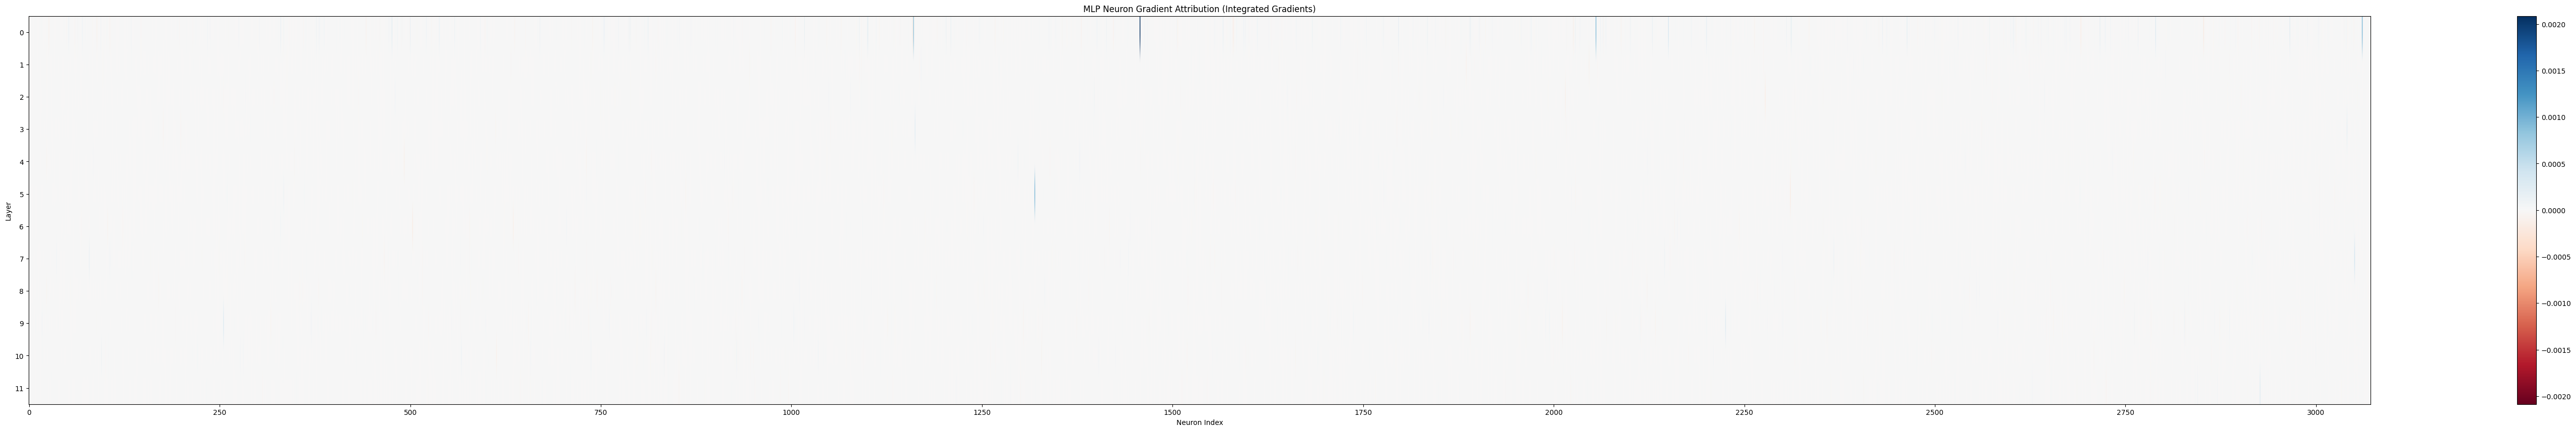

In [123]:
bound = max(torch.max(mlp_ig_results), abs(torch.min(mlp_ig_results)))

plt.figure(figsize=(75, 10))
plt.imshow(mlp_ig_results.detach(), cmap='RdBu', vmin=-bound, vmax=bound, aspect="auto")
plt.title("MLP Neuron Gradient Attribution (Integrated Gradients)")
plt.xticks(np.arange(0, model.cfg.d_mlp, 250))
plt.xlabel("Neuron Index")
plt.yticks(list(range(model.cfg.n_layers)))
plt.ylabel("Layer")
plt.colorbar()
plt.show()

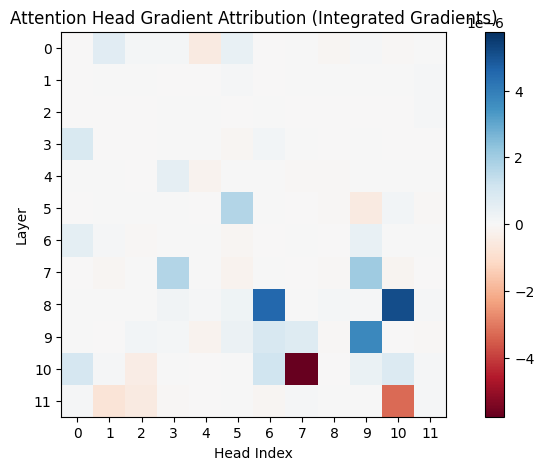

In [121]:
bound = max(torch.max(attn_ig_results), abs(torch.min(attn_ig_results)))

plt.figure(figsize=(10, 5))
plt.imshow(attn_ig_results.detach(), cmap='RdBu', vmin=-bound, vmax=bound)
plt.title("Attention Head Gradient Attribution (Integrated Gradients)")

plt.xlabel("Head Index")
plt.xticks(list(range(model.cfg.n_heads)))

plt.ylabel("Layer")
plt.yticks(list(range(model.cfg.n_layers)))

plt.colorbar()
plt.show()

## Activation Patching

In [126]:
baseline_diff = clean_logit_diff - corrupted_logit_diff

# Patch neurons in MLP layers
mlp_patch_results = torch.zeros(model.cfg.n_layers, model.cfg.d_mlp)
# Patch attention heads
attn_patch_results = torch.zeros(model.cfg.n_layers, model.cfg.n_heads)

def patch_neuron_hook(activations: torch.Tensor, hook: HookPoint, cache: ActivationCache, neuron_idx: int):
    # Replace the activations for the target neuron with activations from the cached run.
    cached_activations = cache[hook.name]
    activations[:, :, neuron_idx] = cached_activations[:, :, neuron_idx]
    return activations

def patch_attn_hook(activations: torch.Tensor, hook: HookPoint, cache: ActivationCache, head_idx: int):
    # Replace the activations for the target attention head with activations from the cached run.
    cached_activations = cache[hook.name]
    activations[:, :, head_idx, :] = cached_activations[:, :, head_idx, :]
    return activations


for layer in range(model.cfg.n_layers):
    # Activation patching on heads
    for head in range(model.cfg.n_heads):
        hook_name = get_act_name("result", layer)
        temp_hook = lambda act, hook: patch_attn_hook(act, hook, corrupted_cache, head)

        with model.hooks(fwd_hooks=[(hook_name, temp_hook)]):
            patched_logits = model(clean_input)

        patched_logit_diff = logits_to_logit_diff(patched_logits).detach()
        # Normalise result by clean and corrupted logit difference
        attn_patch_results[layer, head] = patched_logit_diff / baseline_diff

    # Activation patching on MLP neurons
    for neuron in range(model.cfg.d_mlp):
        hook_name = get_act_name("post", layer)
        temp_hook = lambda act, hook: patch_neuron_hook(act, hook, corrupted_cache, neuron)
        
        with model.hooks(fwd_hooks=[(hook_name, temp_hook)]):
            patched_logits = model(clean_input)

        patched_logit_diff = logits_to_logit_diff(patched_logits).detach()
        # Normalise result by clean and corrupted logit difference
        mlp_patch_results[layer, neuron] = patched_logit_diff / baseline_diff

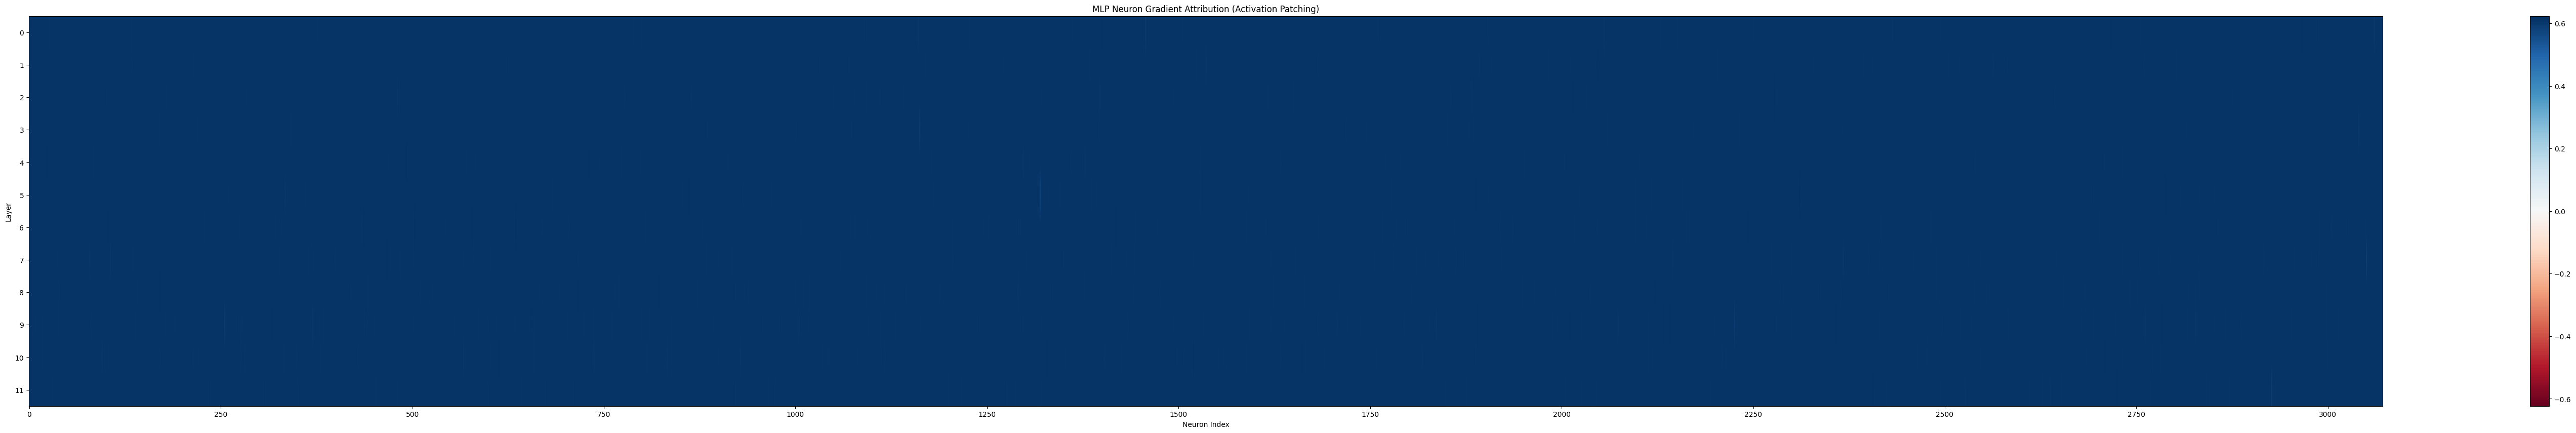

In [127]:
bound = max(torch.max(mlp_patch_results), abs(torch.min(mlp_patch_results)))

plt.figure(figsize=(75, 10))
plt.imshow(mlp_patch_results.detach(), cmap='RdBu', vmin=-bound, vmax=bound, aspect="auto")
plt.title("MLP Neuron Gradient Attribution (Activation Patching)")
plt.xticks(np.arange(0, model.cfg.d_mlp, 250))
plt.xlabel("Neuron Index")
plt.yticks(list(range(model.cfg.n_layers)))
plt.ylabel("Layer")
plt.colorbar()
plt.show()

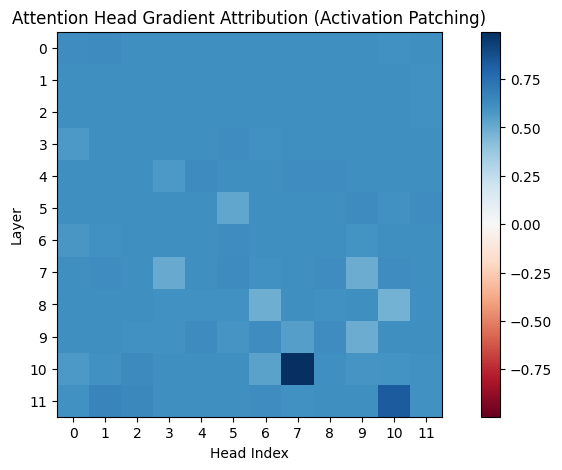

In [128]:
bound = max(torch.max(attn_patch_results), abs(torch.min(attn_patch_results)))

plt.figure(figsize=(10, 5))
plt.imshow(attn_patch_results.detach(), cmap='RdBu', vmin=-bound, vmax=bound)
plt.title("Attention Head Gradient Attribution (Activation Patching)")

plt.xlabel("Head Index")
plt.xticks(list(range(model.cfg.n_heads)))

plt.ylabel("Layer")
plt.yticks(list(range(model.cfg.n_layers)))

plt.colorbar()
plt.show()

# Comparable baselines

*Hypothesis*: One possible reason for the discrepancy between patching and IG is that the range of activations tested may be from different distributions.

Both gradient methods rely on counterfactual reasoning. IG computes the integral between some baseline (which produces zero output) and given input, whereas causal tracing computes the logit difference between two counterfactual inputs. If the counterfactuals used are different, then this could cause a discrepancy.

To evaluate this hypothesis, we compute IG and AP on GPT2-Small with the same counterfactual inputs.